In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch_geometric.loader import DataLoader
from data_utils import *
from tqdm import tqdm
import pandas as pd

import networkx as nx
import torch_geometric.utils as pyg_utils

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from data_utils import *
from graph_vae.vae import GraphVAE

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
include_hydrogen = False

properties = ["homo", "lumo", "r2"]

prop_norm_df = create_or_load_property_norm_df()
    
    # create dataset and dataloaders
dataset = create_qm9_dataset(
    device=device, 
    include_hydrogen=False, 
    refresh_data_cache=False,
    properties=properties,
    prop_norm_df=prop_norm_df
)

_, val_dataset, _ = create_qm9_data_split(dataset=dataset)

mol_indices = [8, 190, 59, 101]
val_dataset = val_dataset[mol_indices]

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = GraphVAE.from_pretrained(checkpoint_path="./checkpoints/graph_vae_20240416_221922.pt").to(device)
model.eval()
model_split = GraphVAE.from_pretrained(checkpoint_path="./checkpoints/graph_vae_20240416_225315.pt").to(device)
model_split.eval()
print()

In [3]:
full_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)
dataset_smiles_with_prop = dict()
for batch in tqdm(full_loader, desc="Converting dataset graphs to SMILES"):
    for sample_index in range(len(batch)):
        sample = batch[sample_index]
        mol = graph_to_mol(data=sample, includes_h=include_hydrogen, validate=False)
        dataset_smiles_with_prop[Chem.MolToSmiles(mol)] = sample.y

Converting dataset graphs to SMILES:   0%|          | 0/501 [00:00<?, ?it/s]

Converting dataset graphs to SMILES: 100%|██████████| 501/501 [03:46<00:00,  2.21it/s]


# Optimize properties with MLE

In [9]:
def optimize_z_for_properties(model, z, properties):
    z.requires_grad_(True)
    optimizer = torch.optim.LBFGS([z], lr=1e-1)

    def closure():
        optimizer.zero_grad()
        y_mu, y_sigma = model.predict_properties(z)
        # var = y_sigma * y_sigma
        loss = ((properties - y_mu) ** 2)

        loss = loss.mean()
        loss.backward()
        return loss
    
    for i in tqdm(range(100)):
        loss = optimizer.step(closure)

    print(f"Property optimization loss = {loss}")
    return z.detach()

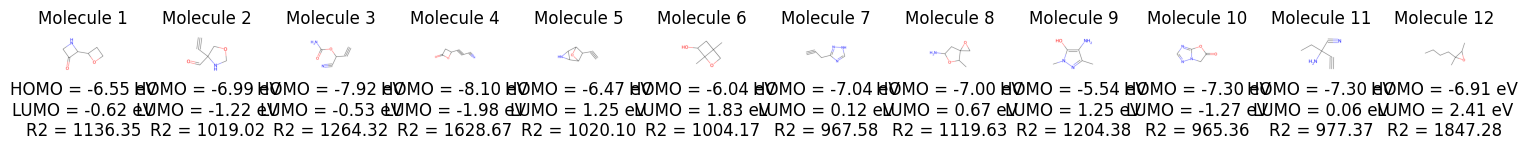

Original z distances to target mol 1: [0.        6.6338434 7.875767  7.2039104 5.776214  6.9025555 6.6608076
 7.1852584 8.3390875 6.018842  7.5431747 7.6493497]


100%|██████████| 100/100 [00:01<00:00, 75.38it/s]


Property optimization loss = 4.4557815770396303e-10
Optimized z distances to target mol 1: [0.        6.4869475 6.7497296 5.394574  5.0545697 6.3326306 6.3182697
 6.291176  8.016722  5.3043184 6.9124484 5.4065723]


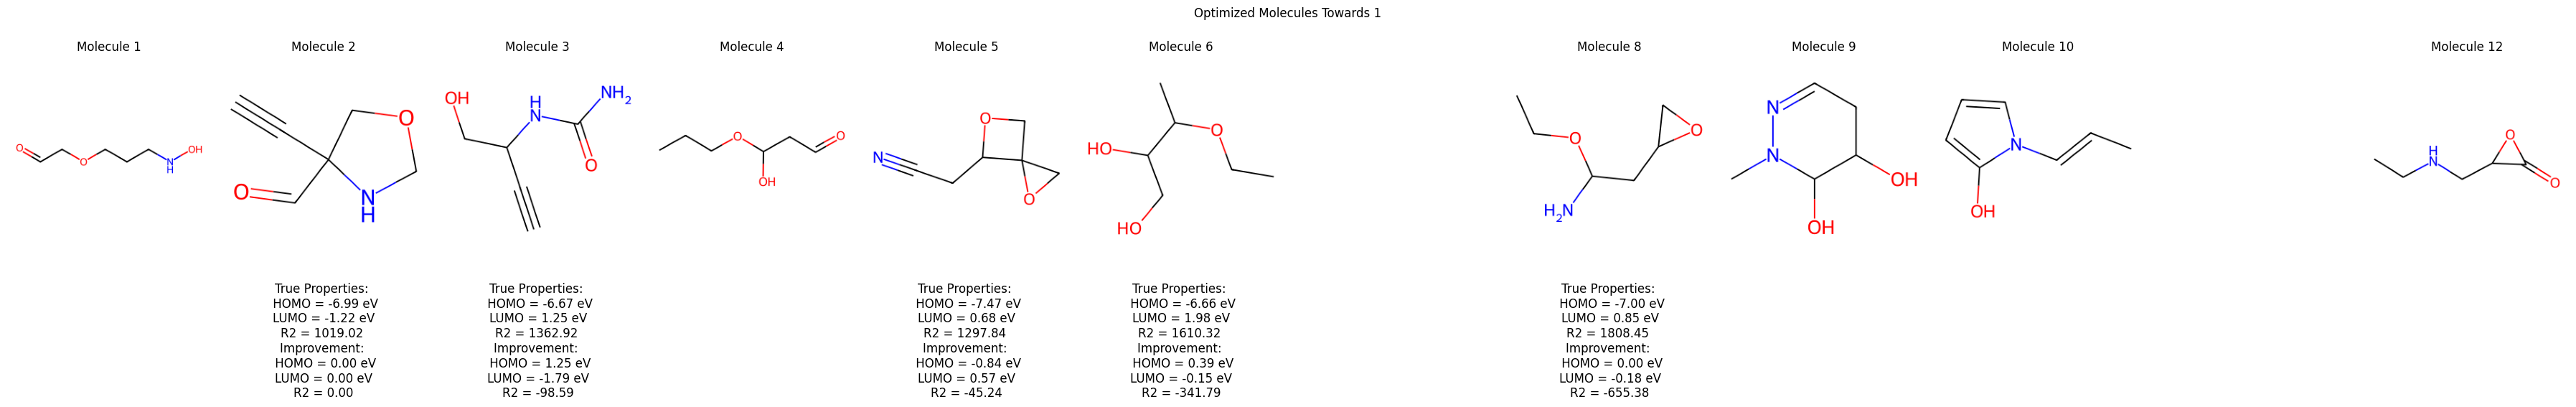

Original z distances to target mol 2: [6.633843  0.        6.4078865 8.137577  7.693595  7.5043206 6.6402774
 7.185492  8.654647  7.0387297 5.3195825 9.656773 ]


100%|██████████| 100/100 [00:01<00:00, 72.23it/s]


Property optimization loss = 4.960916677454463e-10
Optimized z distances to target mol 2: [6.2486606 0.        5.6437902 7.1193132 7.0089326 6.5840983 6.3588233
 6.526082  7.1970534 6.8489084 4.697499  6.9348955]


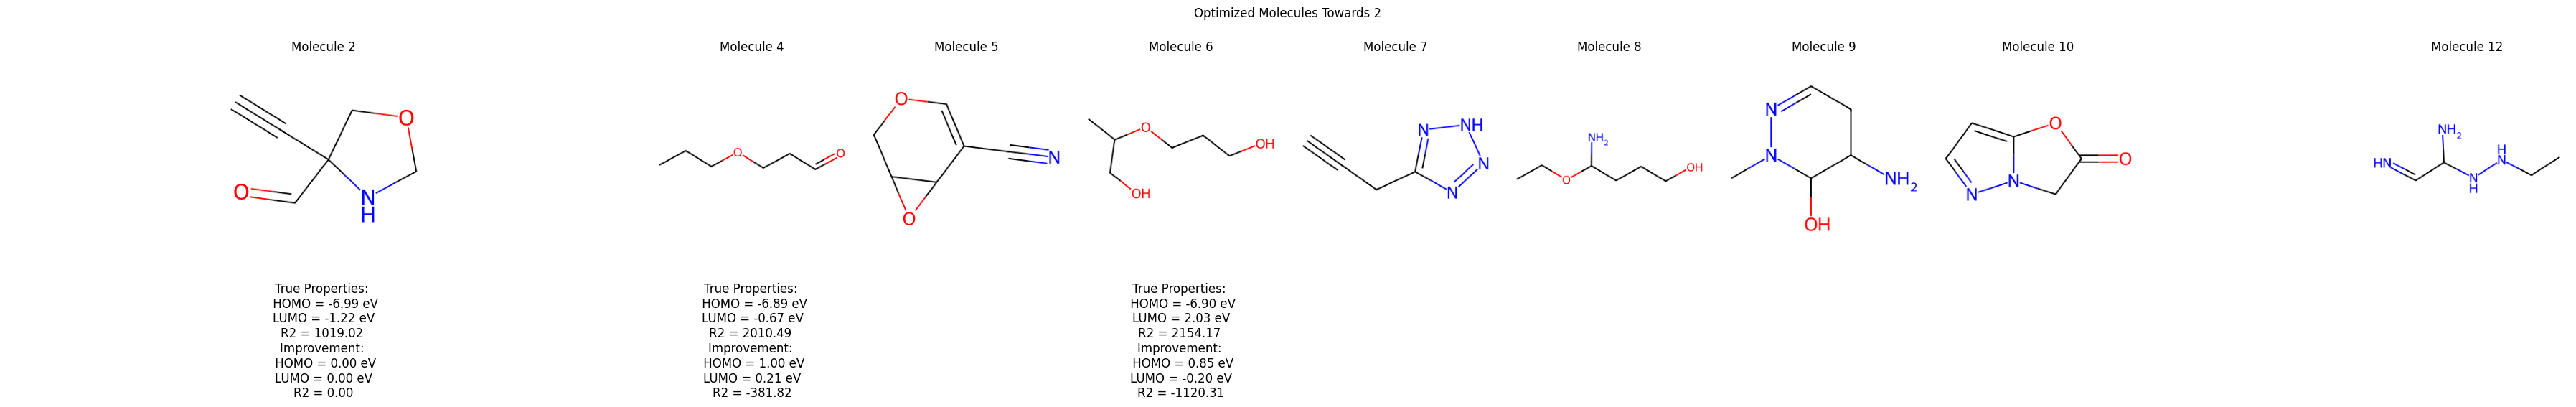

Original z distances to target mol 3: [7.875767  6.4078865 0.        6.2584233 7.6433105 9.115825  7.5378575
 6.8688564 8.8458395 6.938352  6.985806  9.468115 ]


100%|██████████| 100/100 [00:01<00:00, 77.81it/s] 


Property optimization loss = 4.933888297919964e-10
Optimized z distances to target mol 3: [6.804776  5.3896213 0.        5.862016  6.2665877 7.4236746 6.989077
 6.4777617 7.1692567 6.5809197 6.46477   7.734889 ]


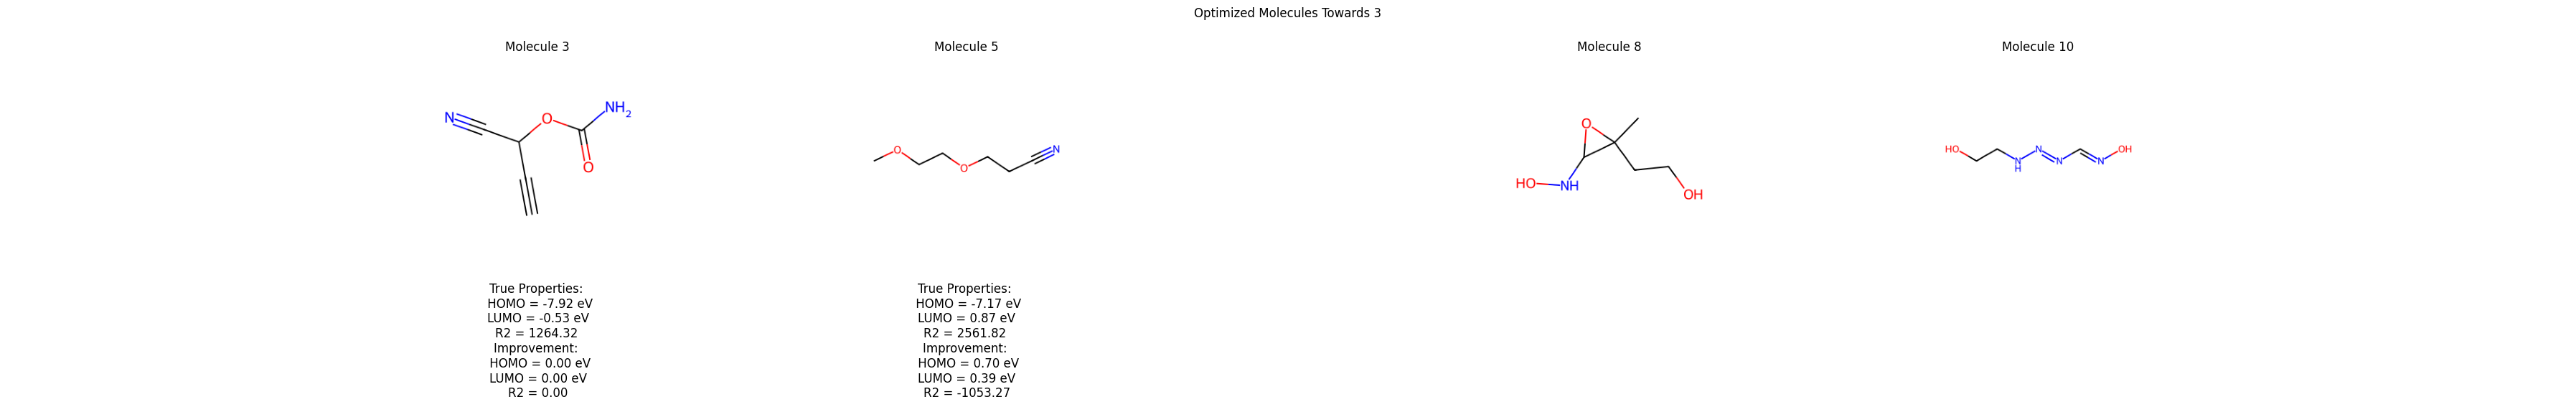

Original z distances to target mol 4: [ 7.2039104  8.137577   6.2584233  0.         8.550966   9.80775
  7.7021484  7.3126616 10.87472    7.0281453  8.395443   8.925155 ]


100%|██████████| 100/100 [00:01<00:00, 81.07it/s]


Property optimization loss = 4.931320352064006e-10
Optimized z distances to target mol 4: [5.4426856 7.4584613 6.204079  0.        6.144411  8.109138  6.1990623
 6.0161095 8.398207  6.097036  7.798124  6.288518 ]


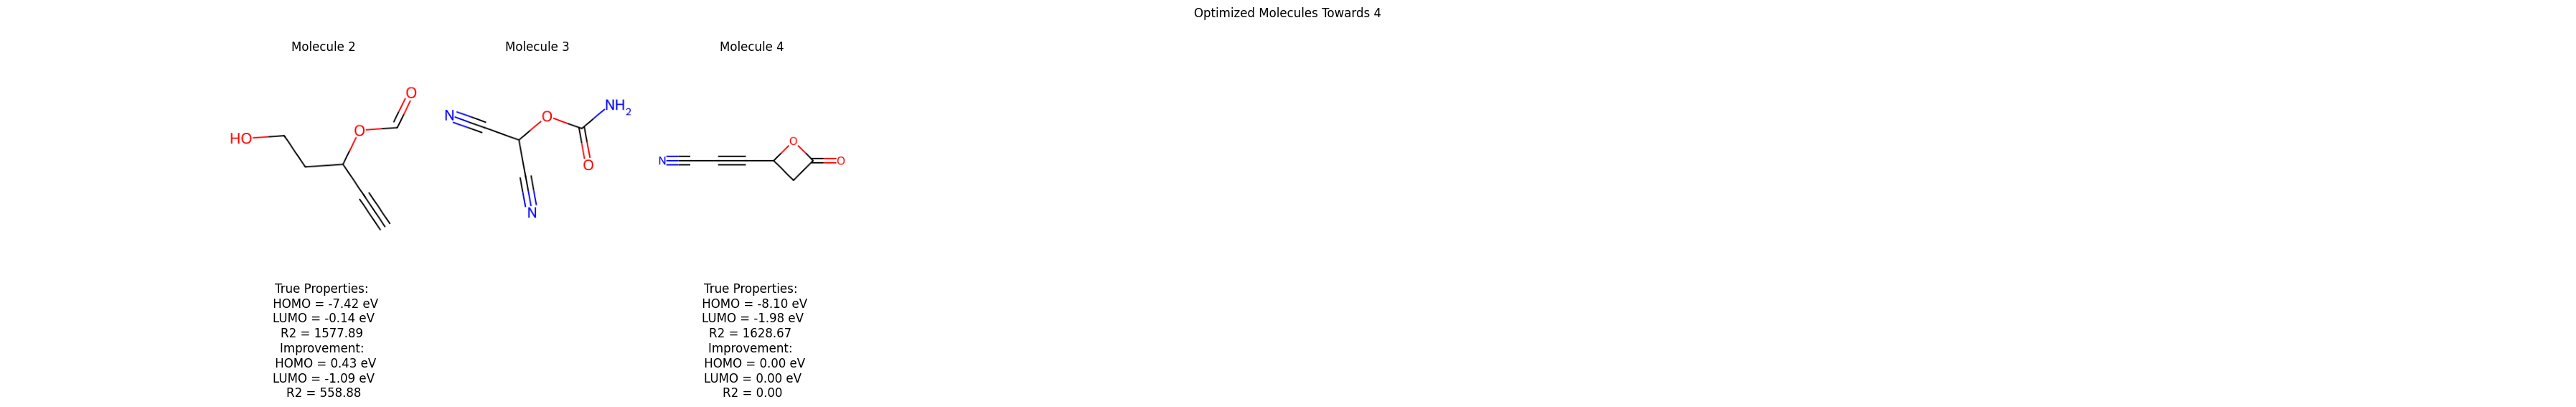

Original z distances to target mol 5: [5.776213  7.693595  7.6433105 8.550966  0.        7.085693  6.618753
 7.821597  8.315583  7.434341  7.562941  9.316596 ]


100%|██████████| 100/100 [00:01<00:00, 72.79it/s]


Property optimization loss = 4.405739384427676e-10
Optimized z distances to target mol 5: [5.001204  7.0245247 6.515947  6.149393  0.        7.069397  6.367876
 7.3829775 7.877144  6.483812  7.3347635 8.235828 ]


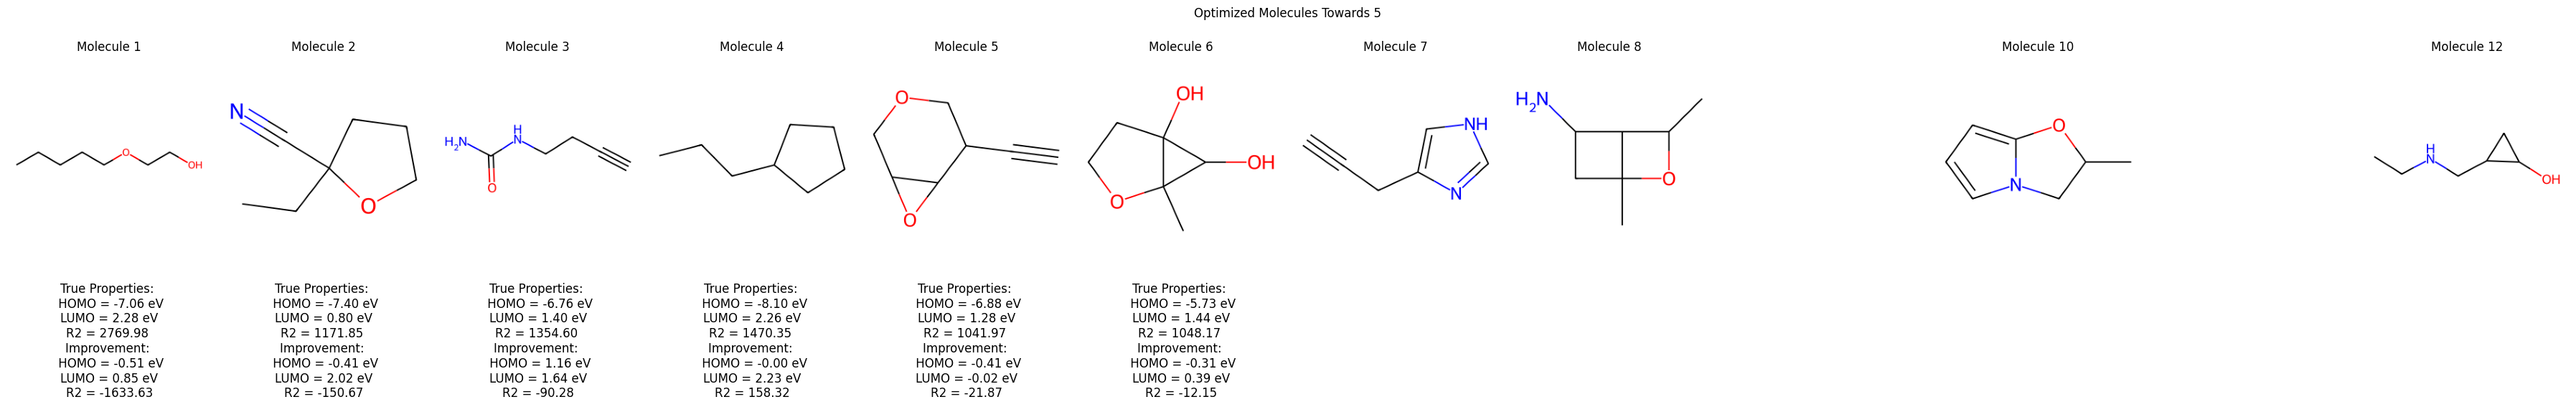

Original z distances to target mol 6: [6.9025555 7.5043197 9.115824  9.80775   7.0856924 0.        8.905753
 7.446403  6.3845887 8.677857  7.388449  6.7232113]


100%|██████████| 100/100 [00:01<00:00, 74.55it/s]


Property optimization loss = 4.635306583011811e-10
Optimized z distances to target mol 6: [6.03186   6.510552  7.624859  6.978907  6.953342  0.        8.589419
 6.2740593 5.6215706 7.719721  6.99208   4.670241 ]


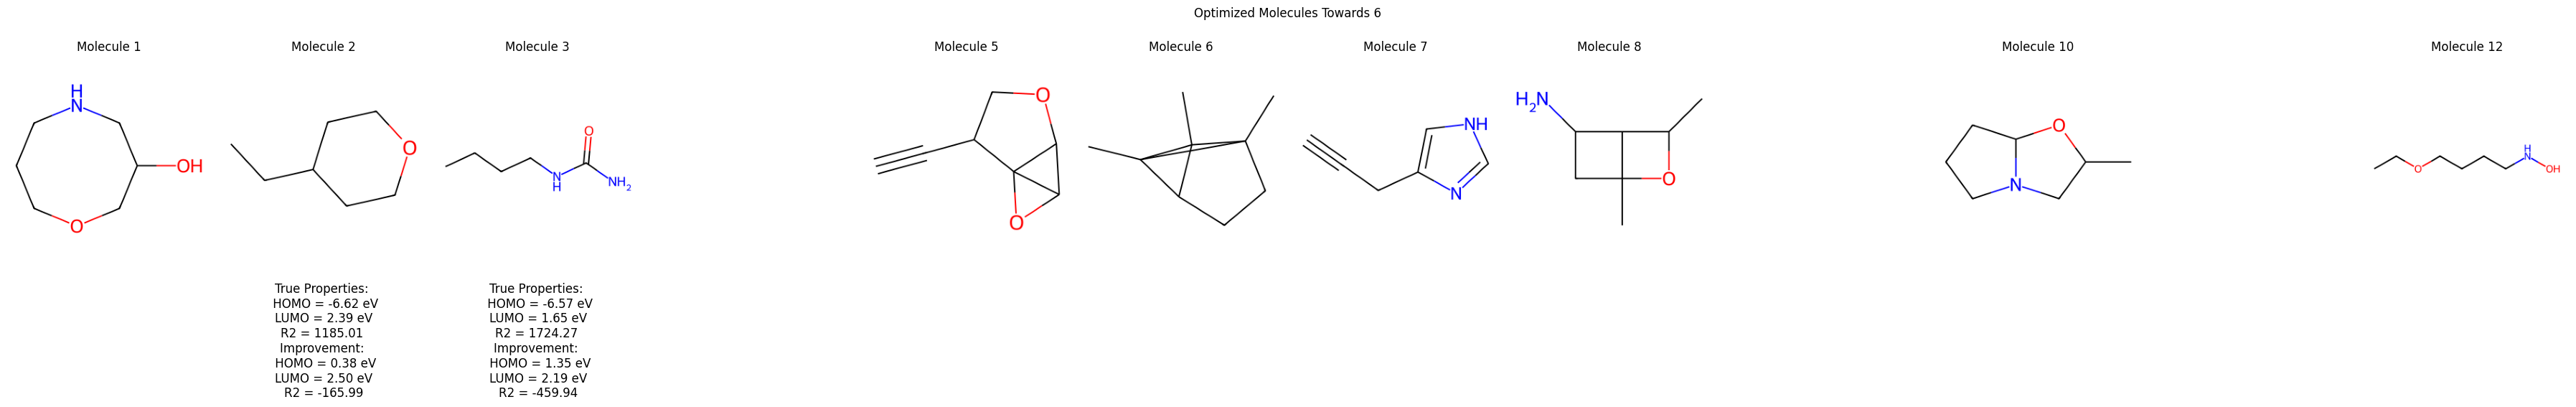

Original z distances to target mol 7: [6.6608076 6.6402774 7.5378575 7.7021484 6.618753  8.905754  0.
 8.164768  8.563543  6.467343  6.8113785 9.388253 ]


100%|██████████| 100/100 [00:01<00:00, 70.85it/s]


Property optimization loss = 4.0878683771339297e-10
Optimized z distances to target mol 7: [5.964886  6.4507966 7.000615  6.485727  6.467949  8.647219  0.
 8.167226  7.664416  6.0860195 6.7310257 8.143344 ]


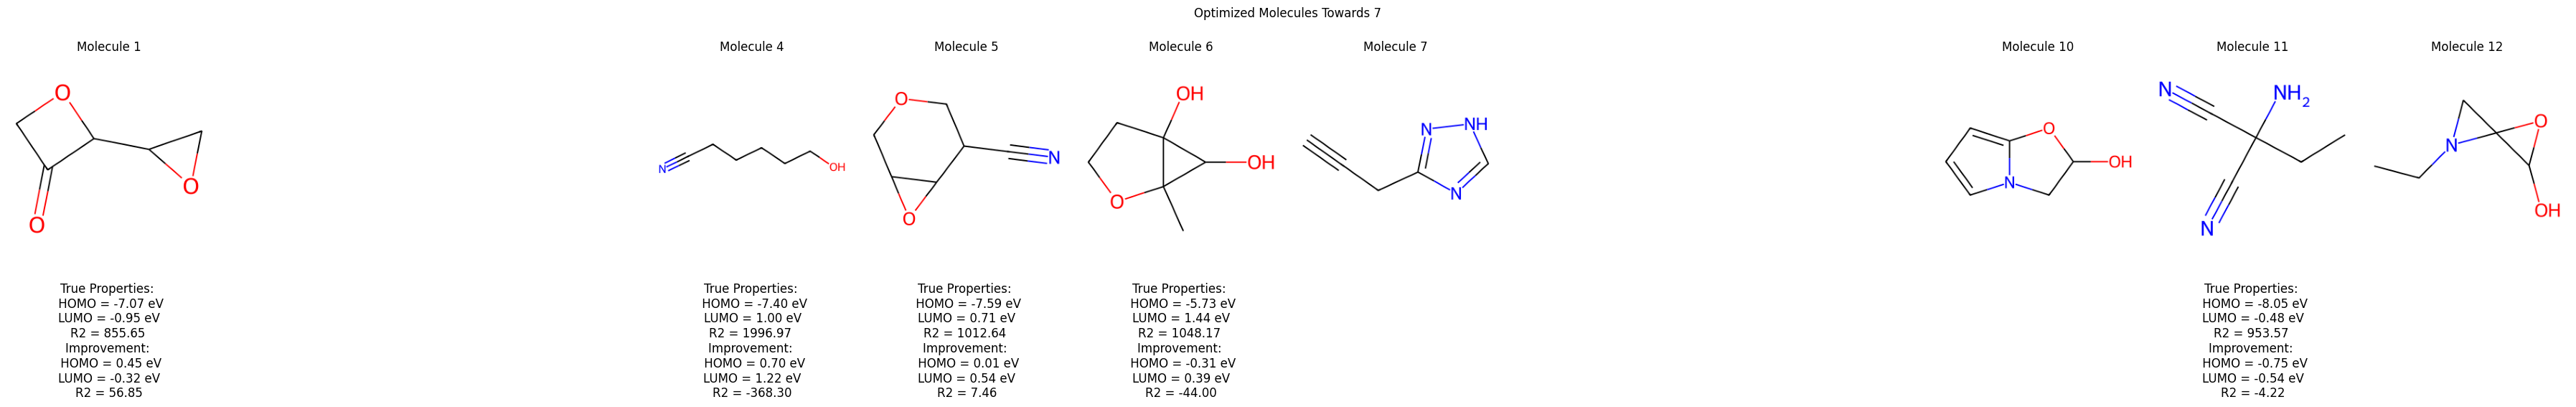

Original z distances to target mol 8: [7.185259  7.1854925 6.868857  7.312661  7.8215966 7.446404  8.164768
 0.        8.059818  7.3582807 7.0316343 7.5659113]


100%|██████████| 100/100 [00:01<00:00, 77.66it/s] 


Property optimization loss = 4.890203242347013e-10
Optimized z distances to target mol 8: [6.519549  6.579489  6.3686957 6.0526814 7.397835  6.83735   7.9621806
 0.        7.2058954 6.7085795 6.8616977 6.5084515]


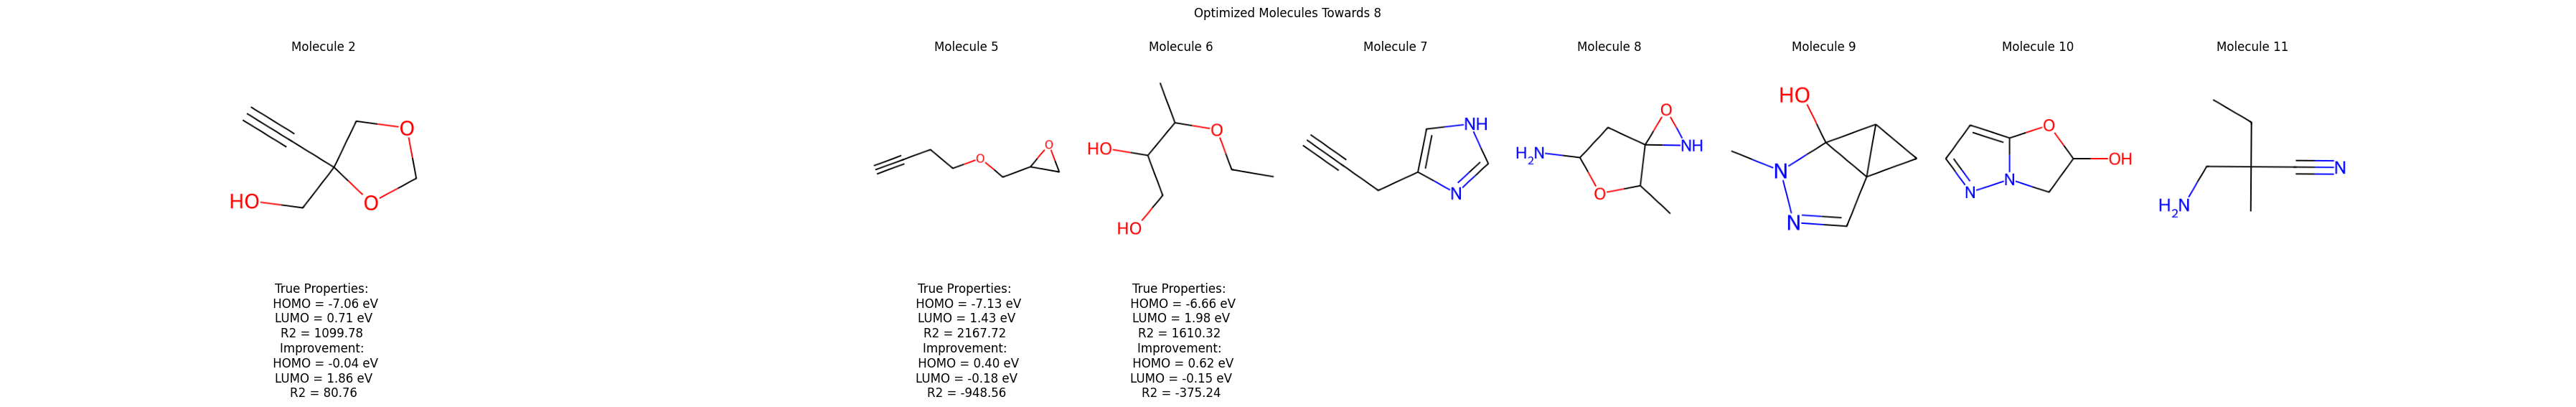

Original z distances to target mol 9: [ 8.3390875  8.654647   8.8458395 10.87472    8.315583   6.3845887
  8.563543   8.059818   0.         8.999984   8.066363   8.21406  ]


100%|██████████| 100/100 [00:01<00:00, 77.55it/s]


Property optimization loss = 4.431426614548428e-10
Optimized z distances to target mol 9: [7.6454825 7.0706954 6.917273  8.070023  7.736225  5.768011  7.74545
 7.020114  0.        7.1494904 6.5933766 7.0817404]


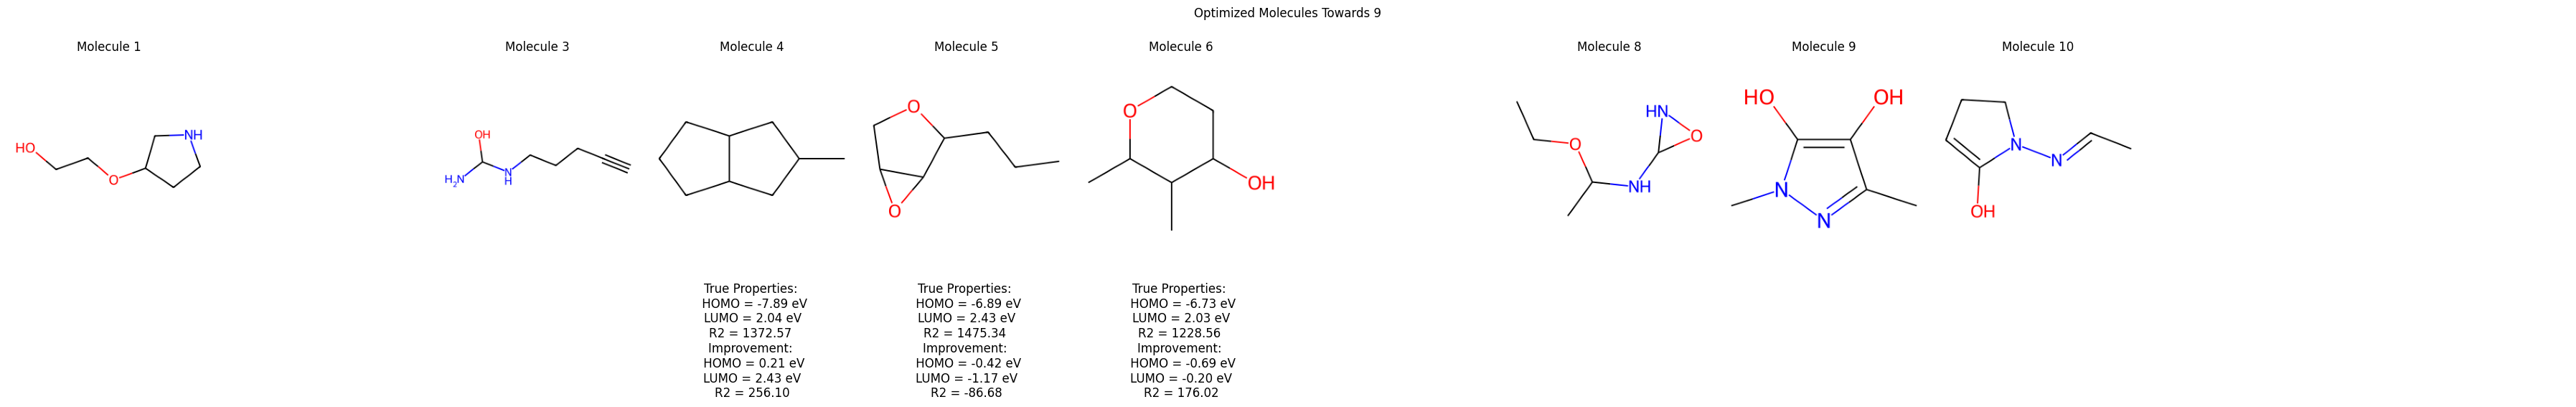

Original z distances to target mol 10: [6.018842  7.0387297 6.938352  7.0281453 7.4343414 8.677857  6.467343
 7.3582797 8.999984  0.        8.3939705 9.566482 ]


100%|██████████| 100/100 [00:01<00:00, 76.35it/s]


Property optimization loss = 4.113105966929709e-10
Optimized z distances to target mol 10: [5.117457  6.8293185 6.2881556 6.2842674 6.643722  7.495888  6.202001
 6.759005  7.270577  0.        8.177955  7.0771856]


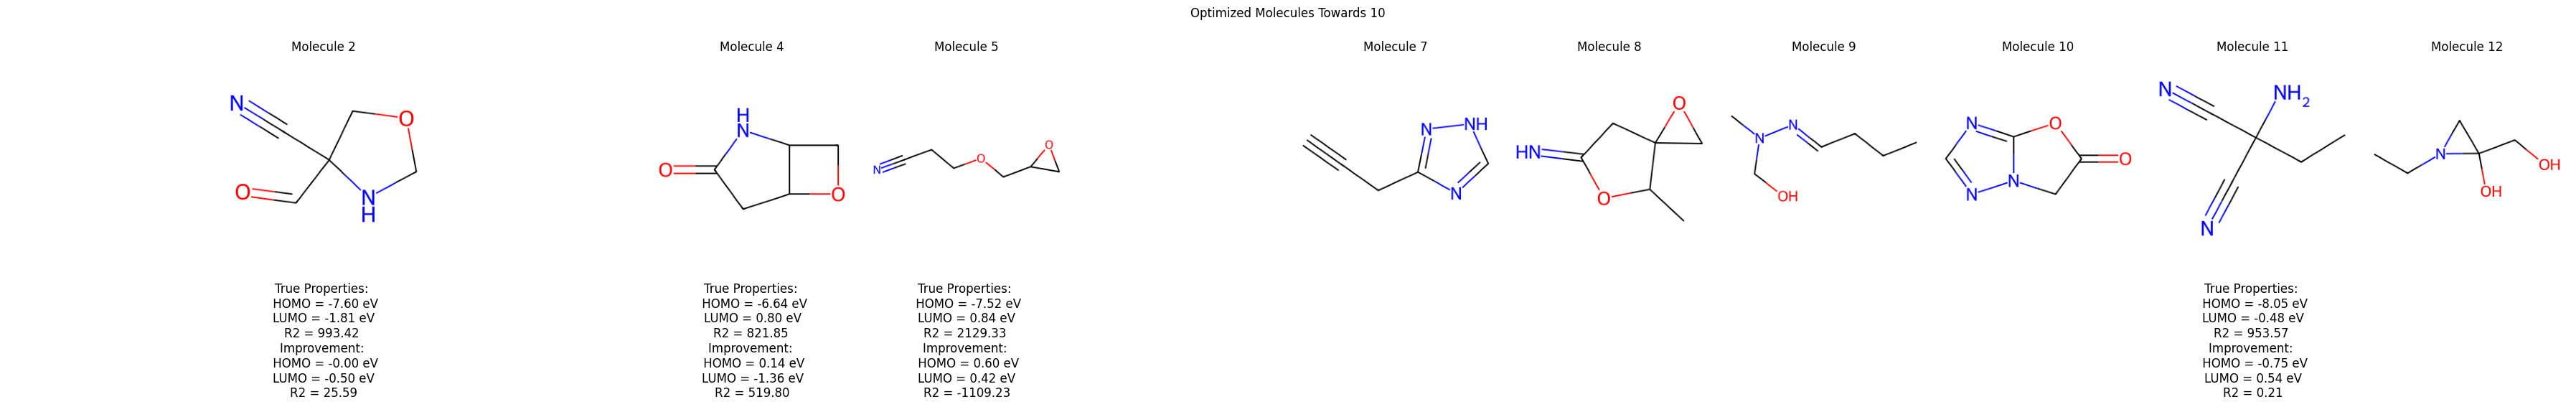

Original z distances to target mol 11: [7.5431747 5.319583  6.985806  8.395443  7.562941  7.3884497 6.8113785
 7.0316343 8.066363  8.3939705 0.        8.674318 ]


100%|██████████| 100/100 [00:01<00:00, 72.97it/s]


Property optimization loss = 4.1246275839235125e-10
Optimized z distances to target mol 11: [6.4831777 4.8965497 6.5713754 7.2648144 7.168794  6.79911   6.720928
 6.9791675 6.77514   8.122142  0.        6.439631 ]


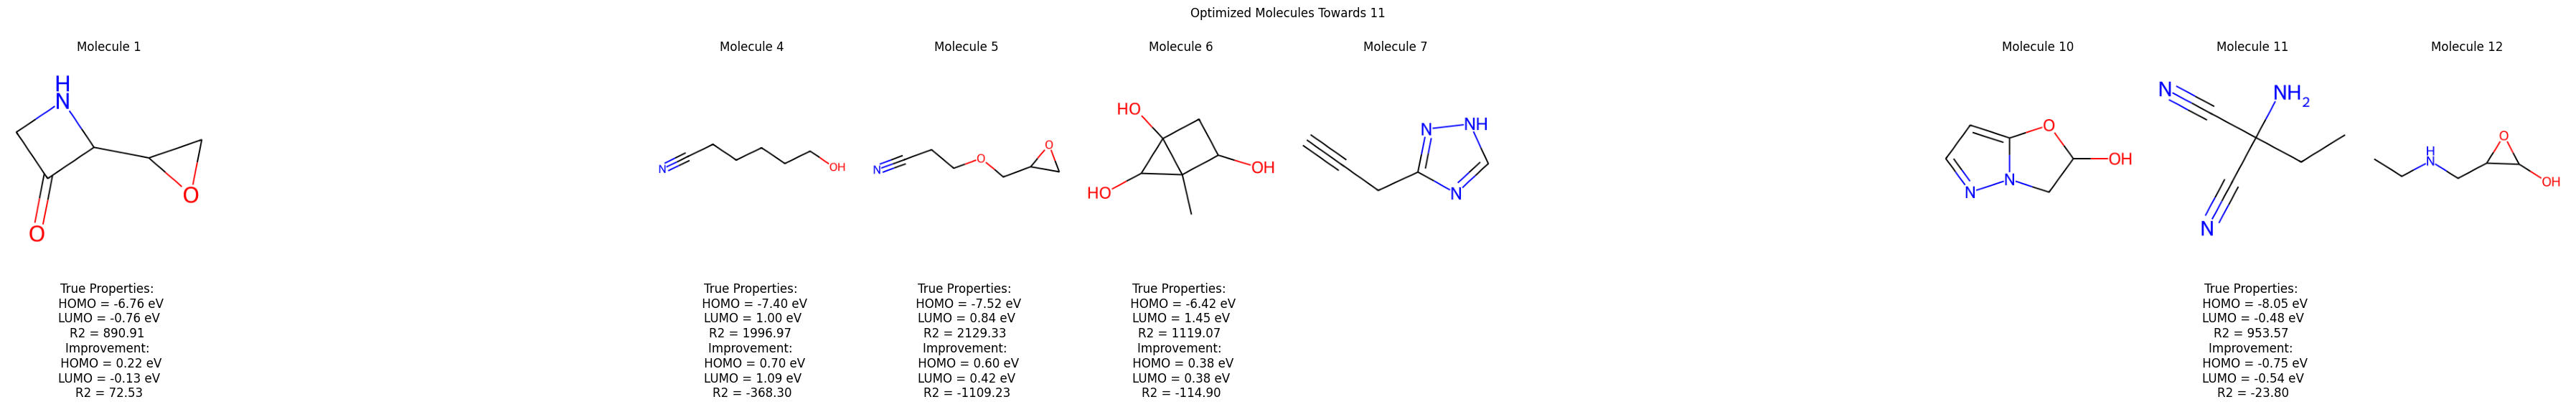

Original z distances to target mol 12: [7.6493497 9.656773  9.468115  8.925155  9.316597  6.723212  9.388253
 7.5659122 8.21406   9.566482  8.674318  0.       ]


100%|██████████| 100/100 [00:01<00:00, 64.17it/s]


Property optimization loss = 4.2337788830337786e-10
Optimized z distances to target mol 12: [5.3212404 7.733337  6.5232143 5.7611074 7.9896083 4.9988422 7.8422613
 5.7453613 7.4353523 6.772872  7.4721727 0.       ]


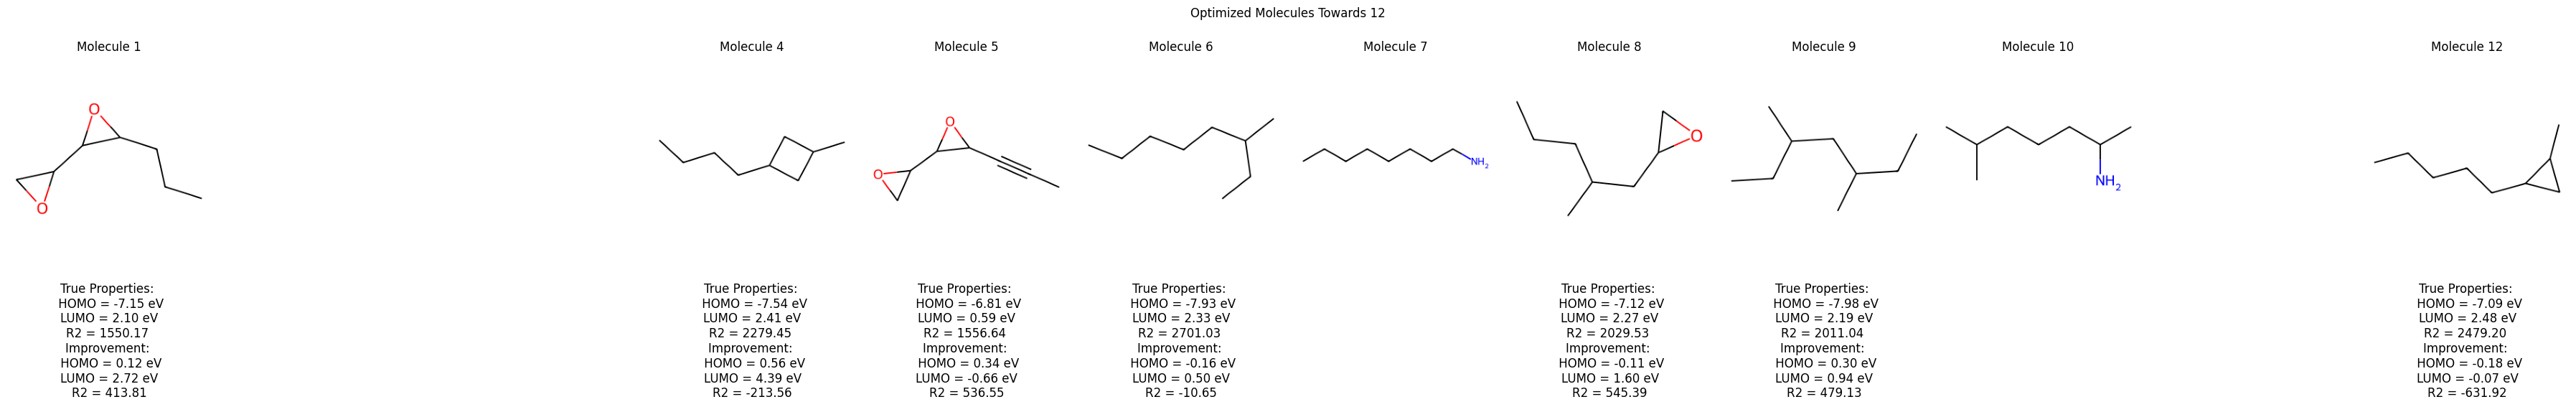

Improvement 
 HOMO: 0.21
 LUMO: 0.58
 R2 -172.55


In [10]:
###################################################
# plot molecules with target properties
###################################################
fig, axs = plt.subplots(1, len(val_dataset), figsize=(15, 4))
for target_mol_index in range(len(val_dataset)):
    src_mol_graph = val_dataset[target_mol_index]
    src_mol = graph_to_mol(src_mol_graph, includes_h=False, validate=False)
    src_mol_img = mol_to_image_tensor(src_mol).transpose(1, 3).transpose(1, 2)

    # Display the molecule image
    ax = axs[target_mol_index]
    ax.imshow(src_mol_img[0])
    ax.set_title(f"Molecule {target_mol_index + 1}")
    ax.axis("off")

    # Retrieve and normalize properties
    properties = model.denormalize_properties(src_mol_graph.y.to(device))[0]
    homo = properties[0]
    lumo = properties[1]
    r2 = properties[2]

    # Display properties as text on the plot
    ax.text(src_mol_img.shape[2]//2, src_mol_img.shape[2] + 32,
            f"HOMO = {homo:.2f} eV\nLUMO = {lumo:.2f} eV\nR2 = {r2:.2f}",
            ha='center', va='top', fontsize=12)

plt.tight_layout()
plt.show()

delta_delta_list = []
for target_mol_index in range(len(val_dataset)):

    ###################################################
    # optimize mols towards target and print distances
    ###################################################
    batch = next(iter(val_loader))
    target_z = model.encode_mean(batch).detach()

    print(f"Original z distances to target mol {target_mol_index + 1}: {torch.cdist(target_z, target_z)[target_mol_index].detach().cpu().numpy()}")
    z = optimize_z_for_properties(
        model=model,
        z=target_z,
        properties=batch[target_mol_index].y
    )
    print(f"Optimized z distances to target mol {target_mol_index + 1}: {torch.cdist(z, target_z)[target_mol_index].detach().cpu().numpy()}")

    target_properties = model.denormalize_properties(batch[target_mol_index].y)
    source_properties = model.denormalize_properties(batch.y)
    original_delta = (target_properties - source_properties).abs()
    
    ###################################################
    # plot optimized mols
    ###################################################
    x = model.decode(z)

    num_mols = len(mol_indices)
    cols = num_mols

    fig, axs = plt.subplots(1, cols, figsize=(cols * 3, 5))  # Adjust size as needed
    fig.suptitle(f"Optimized Molecules Towards {target_mol_index + 1}")
    axs = axs.flatten()  # Flatten to ease the handling of the axis array

    for i in range(num_mols):
        sample_matrices = (x[0][i:i+1], x[1][i:i+1], x[2][i:i+1])

        sample_graph = model.output_to_graph(x=sample_matrices, stochastic=False)

        # Check if the generated graph is connected
        if not nx.is_connected(pyg_utils.to_networkx(sample_graph, to_undirected=True)):
            continue

        try:
            mol = graph_to_mol(data=sample_graph, includes_h=include_hydrogen, validate=True)
        except Exception as e:
            # Molecule is invalid; try to decode again
            continue

        # Molecule is valid
        if mol:
            img = Draw.MolToImage(mol)
            axs[i].imshow(img)
            axs[i].set_title(f"Molecule {i + 1}")
            smiles = Chem.MolToSmiles(mol)
            if smiles in dataset_smiles_with_prop:
                norm_properties = dataset_smiles_with_prop[smiles]
                properties = model.denormalize_properties(norm_properties.to(device))[0]
                homo = properties[0]
                lumo = properties[1]
                r2 = properties[2]
                text = f"True Properties: \n HOMO = {homo:.2f} eV\nLUMO = {lumo:.2f} eV\nR2 = {r2:.2f} \n"

                new_delta = (target_properties - properties).abs()
                # compute the difference between the property distance in the original molecule to the target compared to the distance of the true properties of the optimized molecule
                delta_delta = (original_delta[i] - new_delta)[0]
                text += f"Improvement: \n HOMO = {delta_delta[0]:.2f} eV\nLUMO = {delta_delta[1]:.2f} eV\nR2 = {delta_delta[2]:.2f}"
                if i != target_mol_index:
                    delta_delta_list.append(delta_delta)

                axs[i].text(src_mol_img.shape[2]//2, src_mol_img.shape[2] + 32, 
                        text,
                        ha='center', va="top", fontsize=12)

    for i in range(len(val_dataset)):
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()

delta_deltas = torch.stack(delta_delta_list, dim=0)
mean_property_improvement = delta_deltas.mean(0)
print(f"Improvement \n HOMO: {mean_property_improvement[0]:.2f}\n LUMO: {mean_property_improvement[1]:.2f}\n R2 {mean_property_improvement[2]:.2f}")

# Sample Posterior Subset

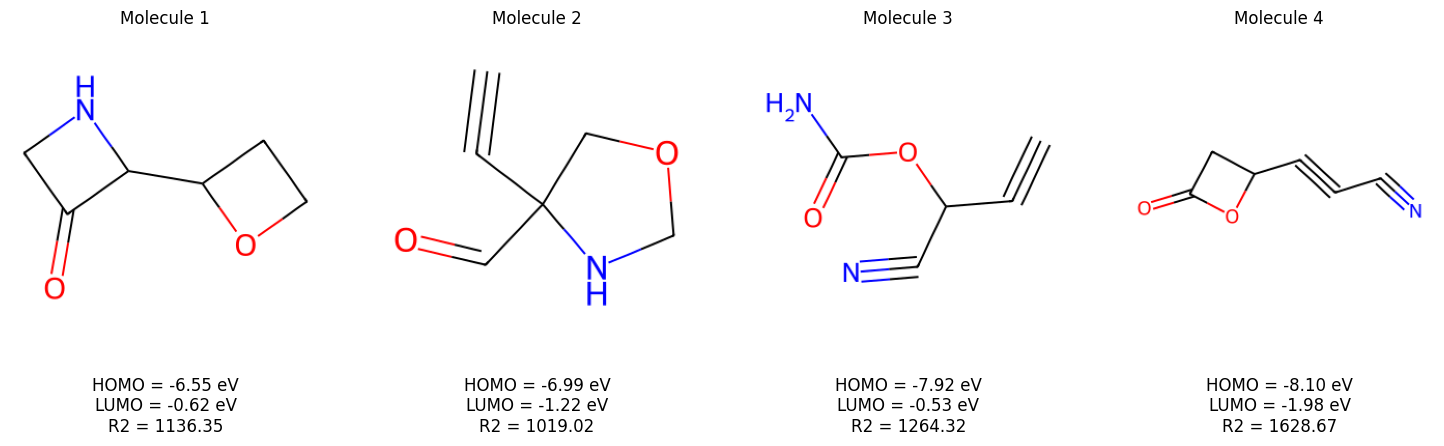

Original z distances to target mol 1: [0.        3.3112829 6.047418  5.1797175]


100%|██████████| 100/100 [00:01<00:00, 80.27it/s]


Property optimization loss = 4.11876283079593e-10
Optimized z distances to target mol 1: [0.        2.7798166 4.976542  3.6770546]


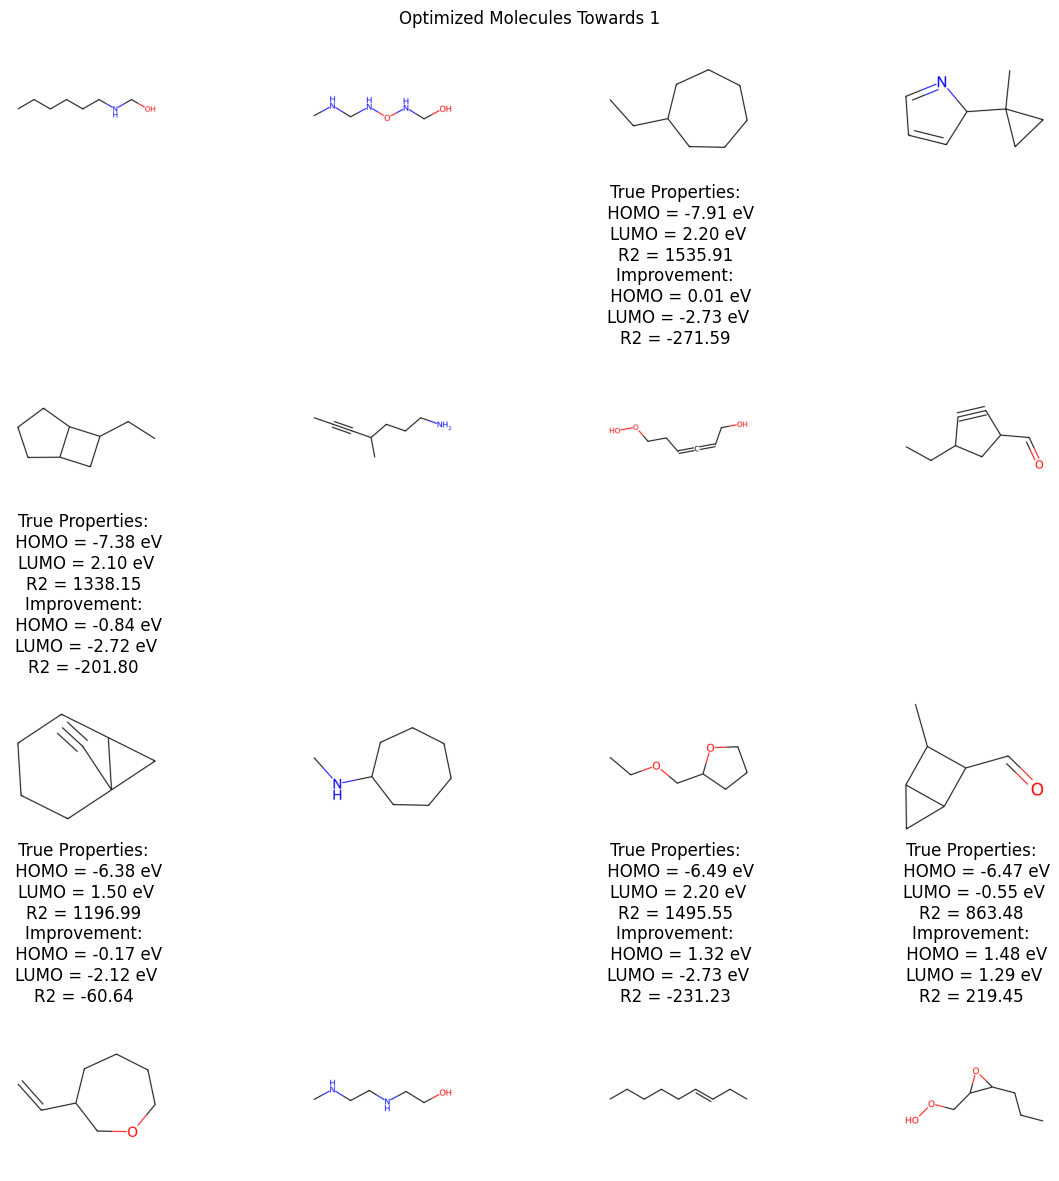

Original z distances to target mol 2: [3.3112838 0.        4.5447264 5.095104 ]


100%|██████████| 100/100 [00:01<00:00, 78.23it/s]


Property optimization loss = 4.3163250751376836e-10
Optimized z distances to target mol 2: [2.8583548 0.        3.4245815 3.92787  ]


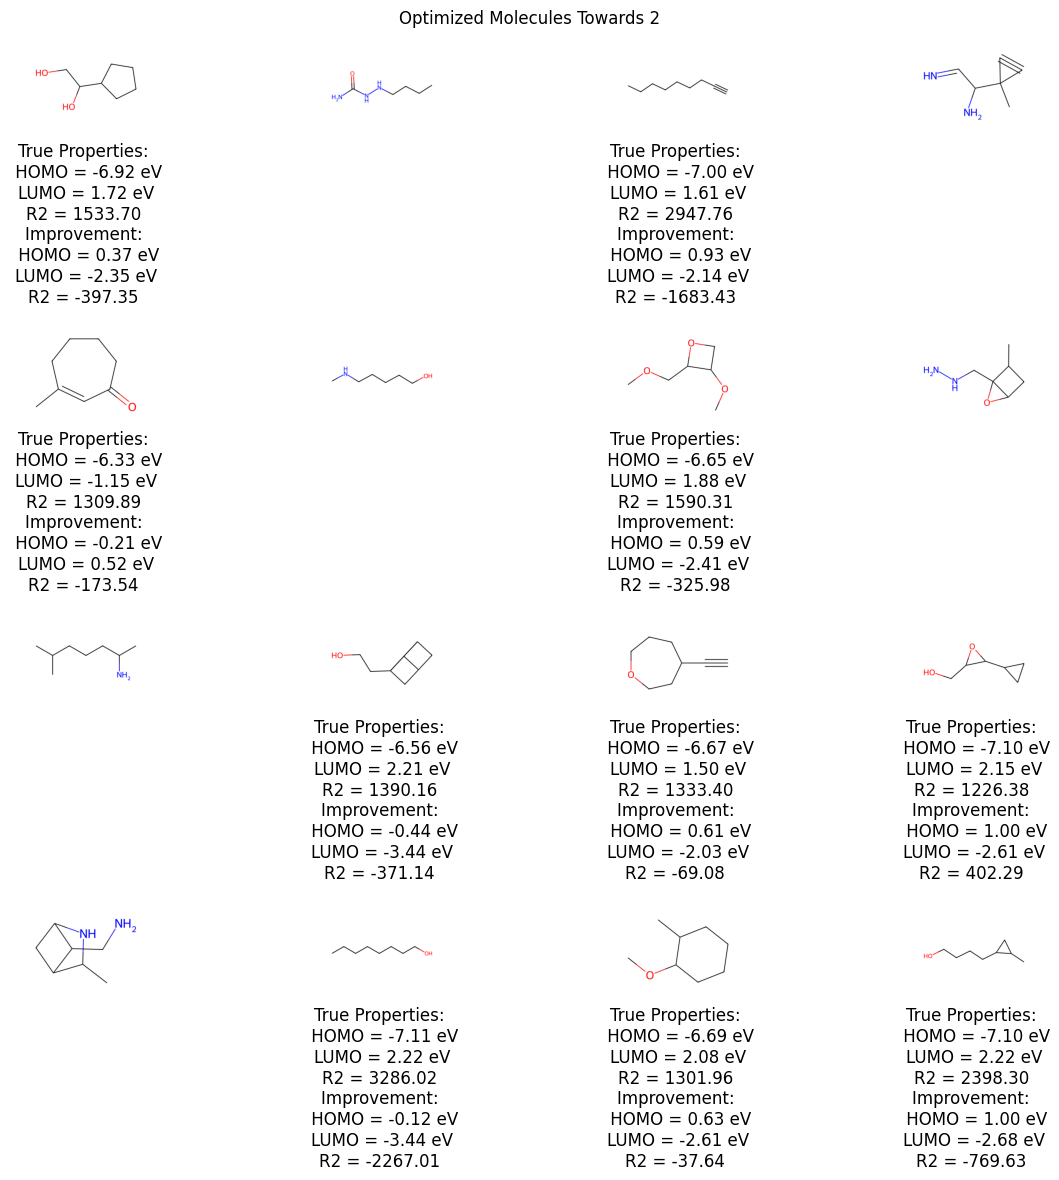

Original z distances to target mol 3: [6.047418  4.544726  0.        4.2349296]


100%|██████████| 100/100 [00:01<00:00, 74.25it/s]


Property optimization loss = 4.4372305829654124e-10
Optimized z distances to target mol 3: [4.9962554 3.5826223 0.        3.7668507]


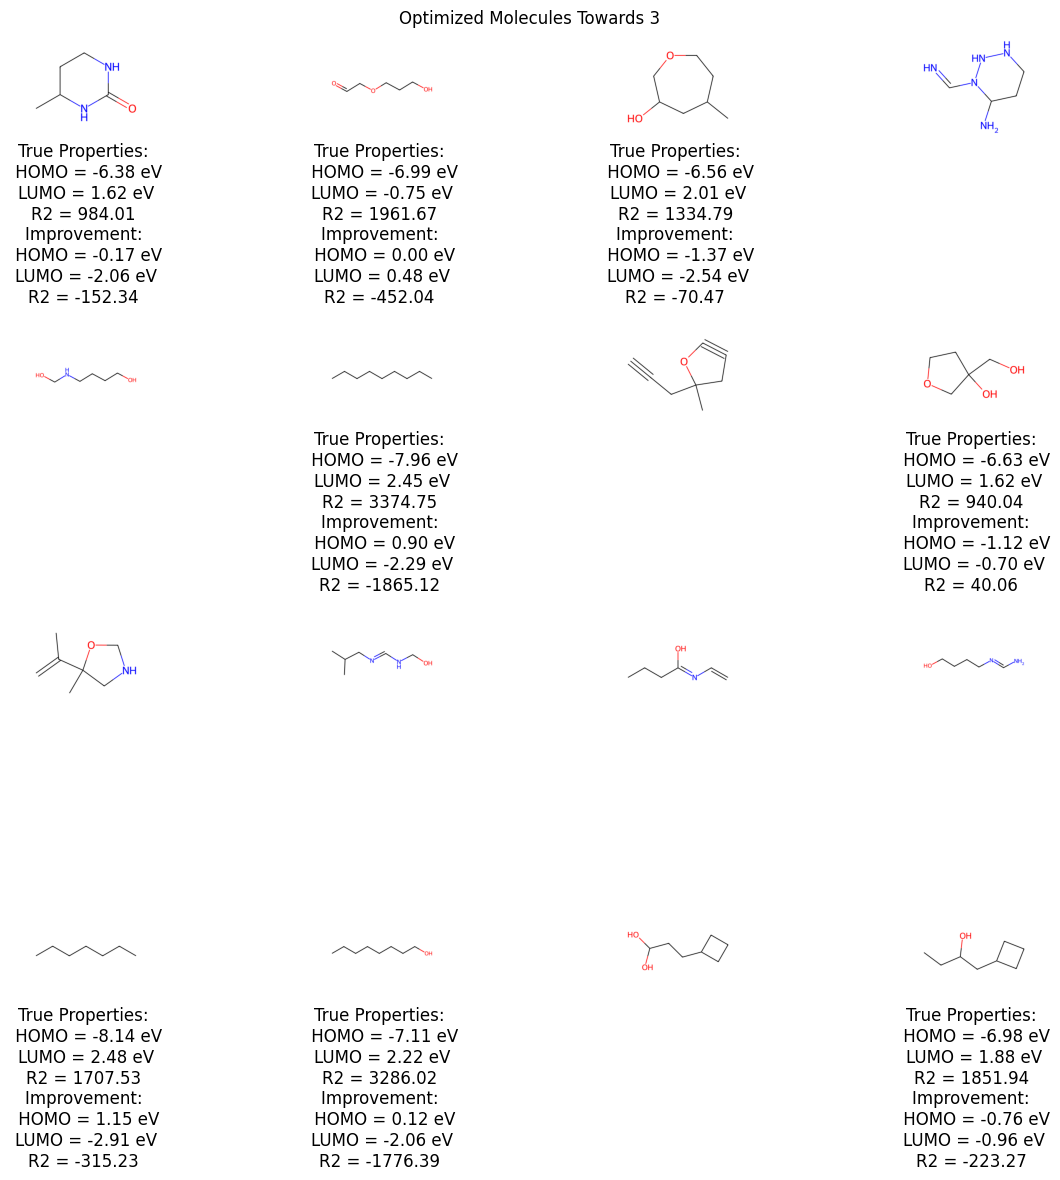

Original z distances to target mol 4: [5.1797175 5.095104  4.2349296 0.       ]


100%|██████████| 100/100 [00:01<00:00, 71.08it/s]


Property optimization loss = 4.3922082637593007e-10
Optimized z distances to target mol 4: [4.592206 3.524847 4.229637 0.      ]


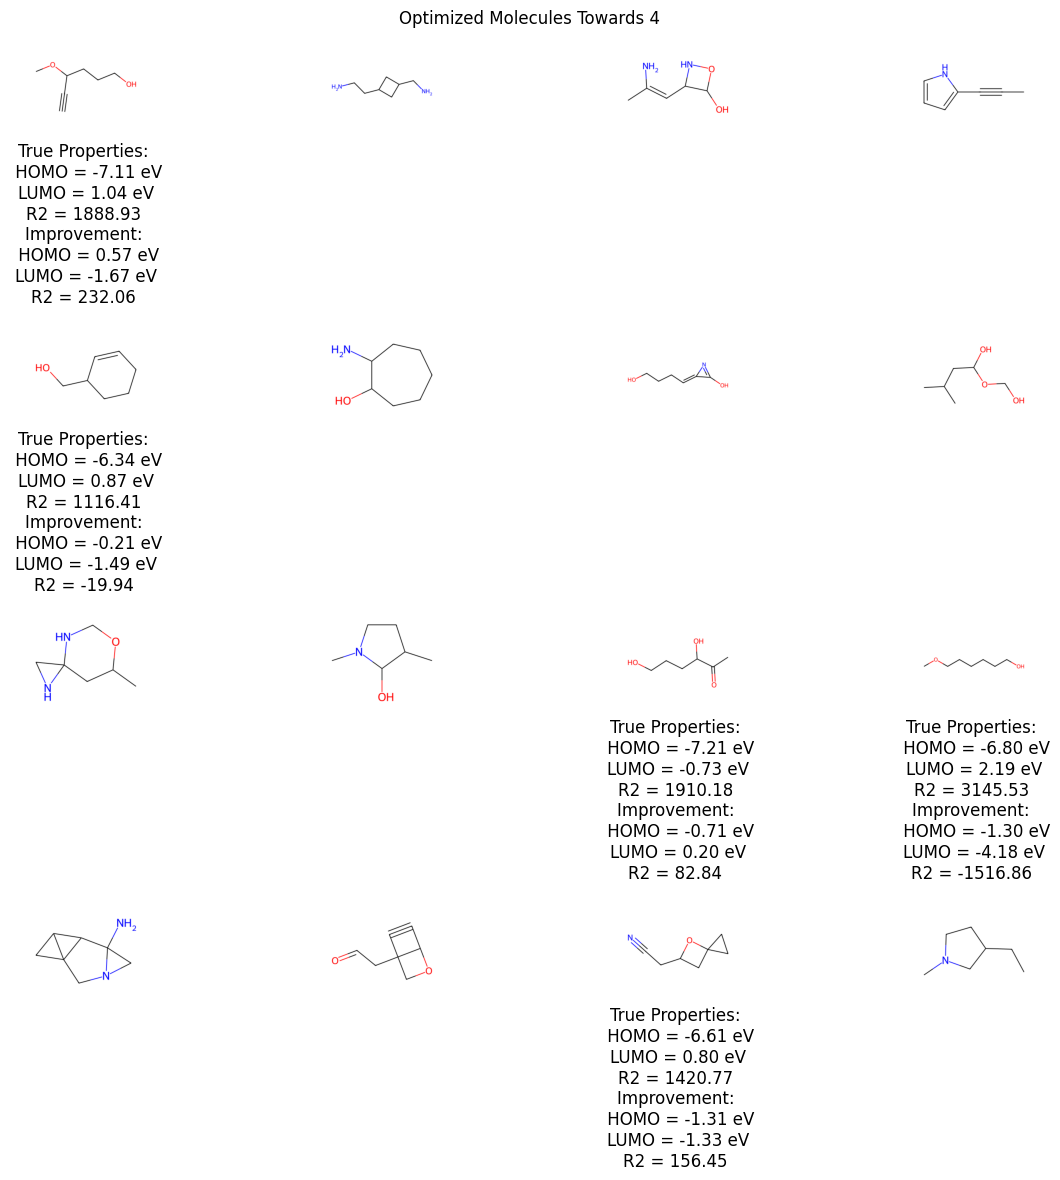

In [48]:
###################################################
# plot molecules with target properties
###################################################
fig, axs = plt.subplots(1, len(val_dataset), figsize=(15, 4))
for target_mol_index in range(len(val_dataset)):
    src_mol_graph = val_dataset[target_mol_index]
    src_mol = graph_to_mol(src_mol_graph, includes_h=False, validate=False)
    src_mol_img = mol_to_image_tensor(src_mol).transpose(1, 3).transpose(1, 2)

    # Display the molecule image
    ax = axs[target_mol_index]
    ax.imshow(src_mol_img[0])
    ax.set_title(f"Molecule {target_mol_index + 1}")
    ax.axis("off")

    # Retrieve and normalize properties
    properties = model.denormalize_properties(src_mol_graph.y.to(device))[0]
    homo = properties[0]
    lumo = properties[1]
    r2 = properties[2]

    # Display properties as text on the plot
    ax.text(src_mol_img.shape[2]//2, src_mol_img.shape[2] + 32,
            f"HOMO = {homo:.2f} eV\nLUMO = {lumo:.2f} eV\nR2 = {r2:.2f}",
            ha='center', va='top', fontsize=12)

plt.tight_layout()
plt.show()


for target_mol_index in range(len(val_dataset)):

    ###################################################
    # optimize mols towards target and print distances
    ###################################################
    batch = next(iter(val_loader))
    target_z = model_split.encode_mean(batch).detach()
    target_z_prop = model_split.z_to_property_z(target_z)

    print(f"Original z distances to target mol {target_mol_index + 1}: {torch.cdist(target_z_prop, target_z_prop)[target_mol_index].detach().cpu().numpy()}")
    z = optimize_z_for_properties(
        model=model_split,
        z=target_z,
        properties=batch[target_mol_index].y
    )
    z_prop = model_split.z_to_property_z(z)
    print(f"Optimized z distances to target mol {target_mol_index + 1}: {torch.cdist(z_prop, target_z_prop)[target_mol_index].detach().cpu().numpy()}")

    target_properties = model.denormalize_properties(batch[target_mol_index].y)
    source_properties = model.denormalize_properties(batch.y)
    original_delta = (target_properties - source_properties).abs()

    ###################################################
    # plot optimized mols
    ###################################################
    random_sample_count = 4
    num_mols = len(mol_indices)
    next_image_index = [0] * num_mols
    cols = num_mols
    fig, axs = plt.subplots(random_sample_count, cols, figsize=(cols * 3, 3 * random_sample_count))  # Adjust size as needed
    fig.suptitle(f"Optimized Molecules Towards {target_mol_index + 1}")

    while any([index < random_sample_count for index in next_image_index]):
    #for random_sample_index in range(random_sample_count):
        random_part = torch.randn(len(val_dataset), 112, device=device)  # 128 - 16 = 112
        
        z = torch.cat((z_prop, random_part), dim=1)
        x = model.decode(z)

        for i in range(num_mols):
            sample_matrices = (x[0][i:i+1], x[1][i:i+1], x[2][i:i+1])

            sample_graph = model_split.output_to_graph(x=sample_matrices, stochastic=False)

            # Check if the generated graph is connected
            if not nx.is_connected(pyg_utils.to_networkx(sample_graph, to_undirected=True)):
                continue

            try:
                mol = graph_to_mol(data=sample_graph, includes_h=include_hydrogen, validate=True)
            except Exception as e:
                # Molecule is invalid; try to decode again
                continue

            # Molecule is valid
            if mol:
                img = Draw.MolToImage(mol)
                image_index = next_image_index[i]
                if image_index >= random_sample_count:
                    continue
                
                next_image_index[i] += 1
                axs[image_index][i].imshow(img)

                smiles = Chem.MolToSmiles(mol)
                text = ""
                if smiles in dataset_smiles_with_prop:
                    norm_properties = dataset_smiles_with_prop[smiles]
                    properties = model_split.denormalize_properties(norm_properties.to(device))[0]
                    homo = properties[0]
                    lumo = properties[1]
                    r2 = properties[2]
                    text += f"True Properties: \n HOMO = {homo:.2f} eV\nLUMO = {lumo:.2f} eV\nR2 = {r2:.2f} \n"
                
                    new_delta = (target_properties - properties).abs()
                    # compute the difference between the property distance in the original molecule to the target compared to the distance of the true properties of the optimized molecule
                    delta_delta = (original_delta[i] - new_delta)[0]
                    text += f"Improvement: \n HOMO = {delta_delta[0]:.2f} eV\nLUMO = {delta_delta[1]:.2f} eV\nR2 = {delta_delta[2]:.2f} "

                axs[image_index][i].text(src_mol_img.shape[2]//2, src_mol_img.shape[2] + 0, 
                        text,
                        ha='center', va="top", fontsize=12)


    for i in range(len(axs)):
        for j in range(len(axs[i])):
            axs[i][j].axis("off")

    plt.tight_layout()
    plt.show()